LANE DETECTION SYSTEM USING HOUGH TRANSFORM
LANE DETECTION 
Loading and preprocessing image
Loading image from: campus_road.jpg
Original image shape: (1706, 1279, 3)
Original image dtype: uint8


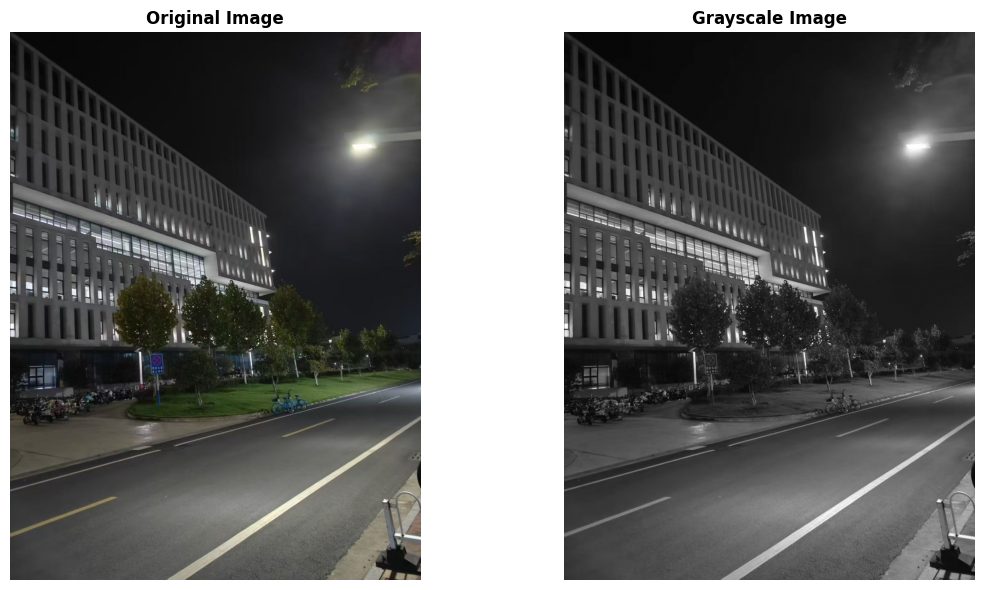


2. Edge detection
 Canny edge detection: low_threshold=50, high_threshold=150
Gaussian blur: kernel_size=5, sigma=1.0


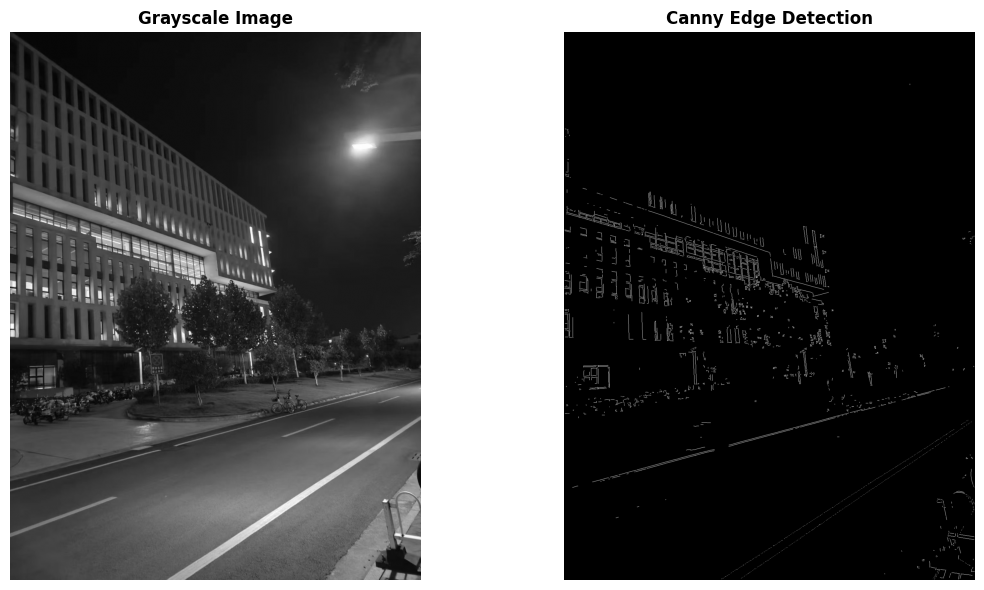


3.Region of interest mask


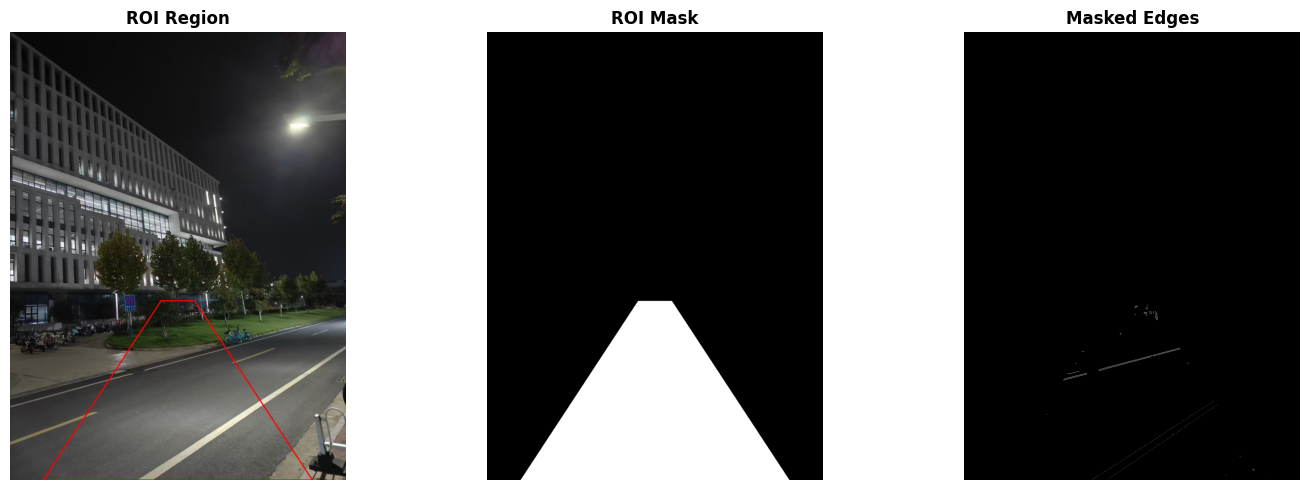


4. Hough Transform
Hough Transform: theta_res=1°, rho_res=2, threshold=50
  Processing 1402 edge points：
  Accumulator shape: (2132, 180)
  Maximum votes: 352
  Detected 81 lines with threshold 50

5. Hough Space


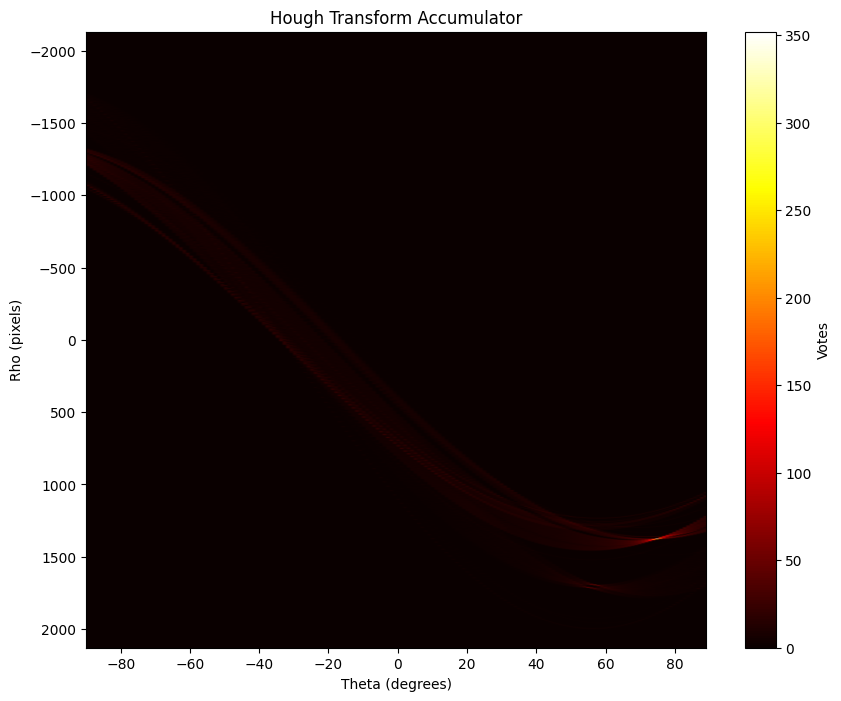


6. Filtering and grouping lines
  Found 4 left lane candidates
  Found 0 right lane candidates
Filtered from 4 to 2 lines
Drawing detected lanes

8. Results


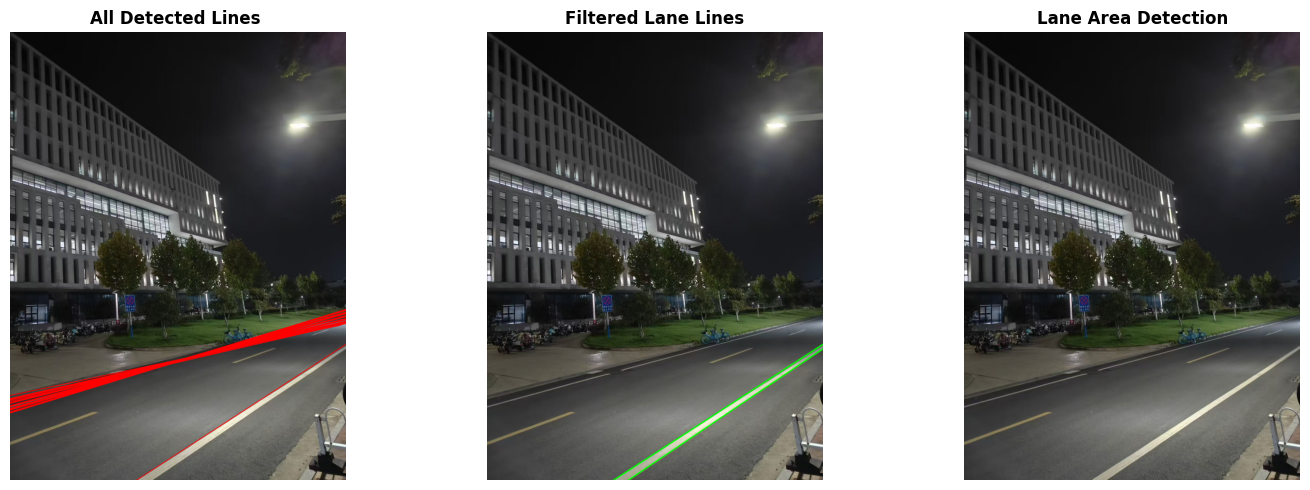


Results saved to lane_output/ directory:
  - lane_output/all_detected_lines.jpg
  - lane_output/filtered_lane_lines.jpg
  - lane_output/lane_area_detection.jpg
Total edge points: 21930
Total lines detected: 81
Left lane lines: 2
Right lane lines: 0

Left lane parameters:
  - ρ: 1694.00 pixels
  - θ: 57.00 degrees
  - Votes: 143


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2


os.makedirs('lane_output', exist_ok=True)
print("LANE DETECTION SYSTEM USING HOUGH TRANSFORM")


def load_and_preprocess(image_path):
    print(f"Loading image from: {image_path}")
    original = np.array(Image.open(image_path))
    print(f"Original image shape: {original.shape}")
    print(f"Original image dtype: {original.dtype}")
    
    if len(original.shape) == 3:
        gray = np.dot(original[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    else:
        gray = original.copy()
    
    return original, gray

def display_images(images, titles, rows, cols, figsize=(15, 10), save_path=None):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
        
    for idx, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:
            axes[idx].imshow(img, cmap='gray')
        else:
            axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def gaussian_blur(image, kernel_size=5, sigma=1.0):
    print(f"Gaussian blur: kernel_size={kernel_size}, sigma={sigma}")
    k = kernel_size // 2
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(-k, k+1):
        for j in range(-k, k+1):
            kernel[i+k, j+k] = np.exp(-(i**2 + j**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    height, width = image.shape
    blurred = np.zeros_like(image, dtype=np.float32)
    padded = np.pad(image, ((k, k), (k, k)), mode='constant')
    
    for i in range(height):
        for j in range(width):
            region = padded[i:i+kernel_size, j:j+kernel_size]
            blurred[i, j] = np.sum(region * kernel)
    return blurred.astype(np.uint8)

def canny_edge_detection(image, low_threshold=50, high_threshold=150):
    print(f" Canny edge detection: low_threshold={low_threshold}, high_threshold={high_threshold}")
    blurred = manual_gaussian_blur(image, kernel_size=5, sigma=1.0)
    # Sobel x
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)
    
    # Sobel y
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=np.float32)
    height, width = blurred.shape
    gradient_x = np.zeros_like(blurred, dtype=np.float32)
    gradient_y = np.zeros_like(blurred, dtype=np.float32)
    padded = np.pad(blurred, ((1, 1), (1, 1)), mode='constant')
    for i in range(height):
        for j in range(width):
            region = padded[i:i+3, j:j+3]
            gradient_x[i, j] = np.sum(region * sobel_x)
            gradient_y[i, j] = np.sum(region * sobel_y)
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    gradient_direction = np.where(gradient_direction < 0, gradient_direction + 180, gradient_direction)

    suppressed = np.zeros_like(gradient_magnitude)    
    for i in range(1, height-1):
        for j in range(1, width-1):
            direction = gradient_direction[i, j]
            mag = gradient_magnitude[i, j]
            if (0 <= direction < 22.5) or (157.5 <= direction <= 180):
                neighbors = [gradient_magnitude[i, j-1], gradient_magnitude[i, j+1]]
            elif 22.5 <= direction < 67.5:
                neighbors = [gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1]]
            elif 67.5 <= direction < 112.5:
                neighbors = [gradient_magnitude[i-1, j], gradient_magnitude[i+1, j]]
            else:  
                neighbors = [gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]]
            
            if mag >= max(neighbors):
                suppressed[i, j] = mag
    
    # 双阈值处理 
    edges = np.zeros_like(suppressed, dtype=np.uint8)
    
    # 强边缘
    strong_edges = suppressed > high_threshold
    # 弱边缘
    weak_edges = (suppressed >= low_threshold) & (suppressed <= high_threshold)
    
    edges[strong_edges] = 255
    
    # 连接弱边缘
    for i in range(1, height-1):
        for j in range(1, width-1):
            if weak_edges[i, j]:
                neighborhood = strong_edges[i-1:i+2, j-1:j+2]
                if np.any(neighborhood):
                    edges[i, j] = 255
    return edges


def create_roi_mask(image_shape, vertices):
    mask = np.zeros(image_shape, dtype=np.uint8)
    
    # 将顶点转换为整数
    vertices = np.array(vertices, dtype=np.int32)
    # 填充多边形
    from matplotlib.path import Path
    h, w = image_shape
    # 创建网格
    y, x = np.mgrid[:h, :w]
    points = np.vstack((x.ravel(), y.ravel())).T
    
    # 创建路径
    path = Path(vertices)
    
    # 测试点是否在多边形内
    grid = path.contains_points(points)
    mask = grid.reshape(h, w).astype(np.uint8) * 255
    
    return mask

# 霍夫变换
def hough_transform(edge_image, theta_res=1, rho_res=1, threshold=100):
  
    print(f"Hough Transform: theta_res={theta_res}°, rho_res={rho_res}, threshold={threshold}")
    
    
    height, width = edge_image.shape
    
    # 计算对角线长度
    diag_len = int(np.sqrt(height**2 + width**2))
    
    # 创建θ和ρ数组
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))
    rhos = np.arange(-diag_len, diag_len, rho_res)
    
    # 初始化累加器
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint32)
    
    # 获取边缘点坐标
    y_idxs, x_idxs = np.where(edge_image > 0)
    
    # 投票过程
    print(f"  Processing {len(x_idxs)} edge points：")
    
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        
        for theta_idx, theta in enumerate(thetas):
            # 计算ρ = x*cosθ + y*sinθ
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            
            # 找到对应的ρ索引
            rho_idx = np.argmin(np.abs(rhos - rho))
            
            # 投票
            accumulator[rho_idx, theta_idx] += 1
    
    print(f"  Accumulator shape: {accumulator.shape}")
    print(f"  Maximum votes: {np.max(accumulator)}")
    
    # 提取直线
    lines = []
    
    # 遍历找到超过阈值的峰值
    peak_indices = np.where(accumulator >= threshold)
    
    for rho_idx, theta_idx in zip(peak_indices[0], peak_indices[1]):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        votes = accumulator[rho_idx, theta_idx]
        
        lines.append({
            'rho': rho,
            'theta': theta,
            'votes': votes
        })
    
    print(f"  Detected {len(lines)} lines with threshold {threshold}")
    
    # 按投票数排序
    lines.sort(key=lambda x: x['votes'], reverse=True)
    
    return lines, accumulator, thetas, rhos

def filter_and_group_lines(lines, angle_threshold=10, rho_threshold=20):

    if not lines:
        return []
    
    # 转换为度
    for line in lines:
        line['theta_deg'] = np.rad2deg(line['theta'])
    
    # 按角度分组
    groups = []
    
    for line in lines:
        added = False
        
        for group in groups:
            # 检查是否属于该组
            if (abs(line['theta_deg'] - group['avg_theta']) < angle_threshold and
                abs(line['rho'] - group['avg_rho']) < rho_threshold):
                
                group['lines'].append(line)
                group['avg_theta'] = np.mean([l['theta_deg'] for l in group['lines']])
                group['avg_rho'] = np.mean([l['rho'] for l in group['lines']])
                added = True
                break
        
        if not added:
            groups.append({
                'lines': [line],
                'avg_theta': line['theta_deg'],
                'avg_rho': line['rho']
            })
    
    # 从每组中选择投票最多的线
    filtered_lines = []
    
    for group in groups:
        if group['lines']:
            best_line = max(group['lines'], key=lambda x: x['votes'])
            filtered_lines.append(best_line)
    
    print(f"Filtered from {len(lines)} to {len(filtered_lines)} lines")
    
    return filtered_lines

def draw_lines_on_image(image, lines, color=(0, 255, 0), thickness=3):

    result = image.copy()
    
    if len(image.shape) == 2:
        result = np.stack([result] * 3, axis=-1)
    
    for line in lines:
        rho = line['rho']
        theta = line['theta']
        
        # 将极坐标转换为笛卡尔坐标
        a = np.cos(theta)
        b = np.sin(theta)
        
        x0 = a * rho
        y0 = b * rho
        
        # 计算直线上的两个点
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        # 绘制直线
        cv2.line(result, (x1, y1), (x2, y2), color, thickness)
    
    return result

def detect_lanes(image_path, output_dir='lane_output'):    
    print("LANE DETECTION ")
    print("Loading and preprocessing image")
    original, gray = load_and_preprocess(image_path)
    
    # 显示原始图像
    display_images([original, gray], 
                  ['Original Image', 'Grayscale Image'], 
                  1, 2, figsize=(12, 6),
                  save_path=f'{output_dir}/01_original_and_gray.png')
    # 边缘检测
    print("\n2. Edge detection")
    edges = manual_canny_edge_detection(gray, low_threshold=50, high_threshold=150)
    
    # 显示边缘检测结果
    display_images([gray, edges],
                  ['Grayscale Image', 'Canny Edge Detection'],
                  1, 2, figsize=(12, 6),
                  save_path=f'{output_dir}/02_edges.png')
    
    print("\n3.Region of interest mask")
    height, width = gray.shape
    
    # 定义感兴趣区域：梯形区域，模拟车道前方
    roi_vertices = [
        (width * 0.1, height),         # 左下
        (width * 0.45, height * 0.6),  # 左上左
        (width * 0.55, height * 0.6),  # 左上右
        (width * 0.9, height)          # 右下
    ]
    
    roi_mask = create_roi_mask(gray.shape, roi_vertices)
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 显示ROI和掩码后的边缘
    roi_visualization = original.copy()
    roi_polygon = np.array(roi_vertices, np.int32)
    roi_polygon = roi_polygon.reshape((-1, 1, 2))
    cv2.polylines(roi_visualization, [roi_polygon], True, (255, 0, 0), 3)
    
    display_images([roi_visualization, roi_mask, masked_edges],
                  ['ROI Region', 'ROI Mask', 'Masked Edges'],
                  1, 3, figsize=(15, 5),
                  save_path=f'{output_dir}/03_roi_and_masked_edges.png')
    
    # 霍夫变换检测
    print("\n4. Hough Transform")
    lines, accumulator, thetas, rhos = manual_hough_transform(
        masked_edges, 
        theta_res=1, 
        rho_res=2, 
        threshold=50
    )
    
    #霍夫空间
    print("\n5. Hough Space")
    plt.figure(figsize=(10, 8))
    plt.imshow(accumulator, aspect='auto', cmap='hot',
              extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), 
                      rhos[-1], rhos[0]])
    plt.xlabel('Theta (degrees)')
    plt.ylabel('Rho (pixels)')
    plt.title('Hough Transform Accumulator')
    plt.colorbar(label='Votes')
    plt.savefig(f'{output_dir}/04_hough_accumulator.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 过滤分组直线
    print("\n6. Filtering and grouping lines")
    
    # 分离左右车道线
    left_lines = []
    right_lines = []
    
    for line in lines:
        theta_deg = np.rad2deg(line['theta'])
        
        # 右车道线：角度在-60°到-30°之间
        if -60 <= theta_deg <= -30:
            right_lines.append(line)
        # 左车道线：角度在30°到60°之间
        elif 30 <= theta_deg <= 60:
            left_lines.append(line)
    
    print(f"  Found {len(left_lines)} left lane candidates")
    print(f"  Found {len(right_lines)} right lane candidates")
    
    # 过滤左右车道线
    filtered_left = filter_and_group_lines(left_lines, angle_threshold=5, rho_threshold=20)
    filtered_right = filter_and_group_lines(right_lines, angle_threshold=5, rho_threshold=20)
    
    #绘制车道线
    print("Drawing detected lanes")
    
    # 绘制所有检测到的线
    all_lines_image = draw_lines_on_image(original, lines[:20], color=(255, 0, 0), thickness=2)
    
    # 绘制过滤后的车道线
    final_lines = filtered_left + filtered_right
    final_result = draw_lines_on_image(original, final_lines, color=(0, 255, 0), thickness=4)
    
    # 创建车道区域可视化
    lane_area = original.copy()
    
    if len(filtered_left) > 0 and len(filtered_right) > 0:
        # 获取左右车道线的参数
        left_line = filtered_left[0]
        right_line = filtered_right[0]
        
        # 计算车道区域
        h, w = original.shape[:2]
        
        # 为左右车道线创建点
        def get_line_points(line, y_bottom, y_top):
            rho = line['rho']
            theta = line['theta']
            
            a = np.cos(theta)
            b = np.sin(theta)
            
            x0 = a * rho
            y0 = b * rho
            
            
            if abs(b) > 1e-6:  
                x_bottom = int((rho - y_bottom * b) / a)
                x_top = int((rho - y_top * b) / a)
                return (x_bottom, y_bottom), (x_top, y_top)
            return None
        
        # 定义车道区域的上下边界
        y_bottom = h
        y_top = int(h * 0.6)
        
        left_points = get_line_points(left_line, y_bottom, y_top)
        right_points = get_line_points(right_line, y_bottom, y_top)
        
        if left_points and right_points:
            # 创建车道区域的多边形
            lane_polygon = np.array([
                left_points[0],  # 左下
                left_points[1],  # 左上
                right_points[1],  # 右上
                right_points[0]   # 右下
            ], np.int32)
            
            # 绘制半透明车道区域
            overlay = lane_area.copy()
            cv2.fillPoly(overlay, [lane_polygon], (0, 255, 0))
            lane_area = cv2.addWeighted(overlay, 0.3, lane_area, 0.7, 0)
            
            # 绘制车道边界
            cv2.line(lane_area, left_points[0], left_points[1], (0, 255, 0), 4)
            cv2.line(lane_area, right_points[0], right_points[1], (0, 255, 0), 4)
    
    print("\n8. Results")
    
    display_images([all_lines_image, final_result, lane_area],
                  ['All Detected Lines ', 
                   'Filtered Lane Lines', 
                   'Lane Area Detection'],
                  1, 3, figsize=(15, 5),
                  save_path=f'{output_dir}/05_final_results.png')
    
    result_paths = {
        'all_lines': f'{output_dir}/all_detected_lines.jpg',
        'filtered_lines': f'{output_dir}/filtered_lane_lines.jpg',
        'lane_area': f'{output_dir}/lane_area_detection.jpg'
    }
    
    cv2.imwrite(result_paths['all_lines'], cv2.cvtColor(all_lines_image, cv2.COLOR_RGB2BGR))
    cv2.imwrite(result_paths['filtered_lines'], cv2.cvtColor(final_result, cv2.COLOR_RGB2BGR))
    cv2.imwrite(result_paths['lane_area'], cv2.cvtColor(lane_area, cv2.COLOR_RGB2BGR))
    
    print(f"\nResults saved to {output_dir}/ directory:")
    for key, path in result_paths.items():
        print(f"  - {path}")
    
    results = {
        'original': original,
        'gray': gray,
        'edges': edges,
        'masked_edges': masked_edges,
        'lines': lines,
        'filtered_left': filtered_left,
        'filtered_right': filtered_right,
        'final_result': final_result,
        'lane_area': lane_area,
        'accumulator': accumulator
    }
    
    return results


def create_sample_road_image():
    print("sample road image for test:")
    height, width = 600, 800
    image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 设置道路颜色
    road_color = (100, 100, 100)
    image[:, :] = road_color
    
    # 添加车道线
    lane_color = (255, 255, 255)  
    
    # 左车道线
    cv2.line(image, (width//2 - 100, height), (width//2 - 50, height//2), lane_color, 8)
    cv2.line(image, (width//2 - 50, height//2), (width//2 - 100, 0), lane_color, 8)
    
    # 右车道线
    cv2.line(image, (width//2 + 100, height), (width//2 + 50, height//2), lane_color, 8)
    cv2.line(image, (width//2 + 50, height//2), (width//2 + 100, 0), lane_color, 8)
    
    for i in range(0, width, 50):
        cv2.line(image, (i, 0), (i, height), (120, 120, 120), 1)
        
    cv2.imwrite('sample_road.jpg', image)
    print("Sample road image saved as 'sample_road.jpg'")
    
    return image

def main():
    image_path = 'campus_road.jpg'  
    if not os.path.exists(image_path):
        print(f"Image '{image_path}' not found.")
        create_sample_road_image()
        image_path = 'campus_road.jpg'
        print(f"Using sample image: {image_path}")
    
    try:
        results = detect_lanes(image_path)
        print(f"Total edge points: {np.sum(results['edges'] > 0)}")
        print(f"Total lines detected: {len(results['lines'])}")
        print(f"Left lane lines: {len(results['filtered_left'])}")
        print(f"Right lane lines: {len(results['filtered_right'])}")
        
        if results['filtered_left']:
            left = results['filtered_left'][0]
            print(f"\nLeft lane parameters:")
            print(f"  - ρ: {left['rho']:.2f} pixels")
            print(f"  - θ: {np.rad2deg(left['theta']):.2f} degrees")
            print(f"  - Votes: {left['votes']}")
        
        if results['filtered_right']:
            right = results['filtered_right'][0]
            print(f"\nRight lane parameters:")
            print(f"  - ρ: {right['rho']:.2f} pixels")
            print(f"  - θ: {np.rad2deg(right['theta']):.2f} degrees")
            print(f"  - Votes: {right['votes']}")
        
    except Exception as e:
        print(f"\nError during lane detection: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [2]:
!pip install opencv-python

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 14.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
